In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import os.path as path
import sys
import re
import json
import datetime
from datetime import timedelta

import theano
import theano.tensor as t
import pymc3 as pm
from pymc3.model_graph import ModelGraph, model_to_graphviz
from pymc3 import glm

from IPython.display import display, Markdown, Latex

from utils import kde_scatter, bayesian_correlation, summary

import warnings
warnings.filterwarnings("ignore", "dropping on a non-lexsorted multi-index without a level parameter may impact performance", append=True)


%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = "24"
sns.set(font_scale=1.5)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 16)

In [5]:
DATAPATH = 'data/SN2'

In [26]:
dfs = []
df_values = []

for file in [x for x in os.listdir(DATAPATH) if '.json' in x]:
    with open(os.path.join(DATAPATH, file), 'r') as f:
        data = json.load(f)
        df = pd.DataFrame(data.pop('activity'))
        day = re.findall('[0-9]{4}-[0-9]{2}-[0-9]{2}', file)[0]
        df['day'] = day
        df['datetime'] = pd.to_datetime(df.day + ' ' + df.activity_time)
        df = df.drop(columns=['activity_time', 'day'])
        dfs.append(df)
        
        data['day'] = pd.to_datetime(day)
        df_values.append(data)
        
df = pd.concat(dfs).reset_index(drop=True)

df = df.sort_values('datetime')

# Count nighttime spent
df['timespent'] = -(df.datetime.astype(np.int64).diff(-1)//1e9).apply(lambda x: pd.Timedelta(seconds=x) if not np.isnan(x) else pd.Timedelta(seconds=0))
# if next day is missing remove 1 day from timespent
df.timespent = df.timespent.apply(lambda x : x-pd.Timedelta(days=1) if x > pd.Timedelta(days=1) else x)

# Activity type to categories
df.activity_type = df.activity_type.str.strip()
df.activity_type = df.activity_type.astype('category')

df = df.iloc[:-1] # remove last sleep

df_values = pd.DataFrame(df_values)
df_values = df_values.set_index('day')
df_values = df_values.rename(columns={'tiredness':'fatigue', 'workload':'effort physique'})

![Sentinelle Nord](https://sentinellenord.ulaval.ca/themes/custom/sn_front/sn_integration/app/assets/images/components/logo-sentinelle-noir-fr.png "Sentinelle Nord")

# Raport initial expédition 2018 SN 2.8
## participant 1



# Statistiques de base

### Exemple de données récoltées

In [27]:
df.head()

,activity_name,activity_type,datetime,timespent
0,mise en place openIMU (calibration) + montre 2...,Lever (nuit),2018-08-21 01:30:00,00:05:00
1,préparation en prévision de la station d'échan...,Déplacements à la marche,2018-08-21 01:35:00,00:25:00
2,travail sur le pont,Travail en position assise,2018-08-21 02:00:00,01:30:00
3,travail au labo,Travail en position debout/accroupie,2018-08-21 03:30:00,03:00:00
4,pause & lunch,Repas (en position assise),2018-08-21 06:30:00,00:20:00


In [28]:
with pd.option_context('display.max_rows', 100000):
    display(df)

,activity_name,activity_type,datetime,timespent
0,mise en place openIMU (calibration) + montre 2...,Lever (nuit),2018-08-21 01:30:00,00:05:00
1,préparation en prévision de la station d'échan...,Déplacements à la marche,2018-08-21 01:35:00,00:25:00
2,travail sur le pont,Travail en position assise,2018-08-21 02:00:00,01:30:00
3,travail au labo,Travail en position debout/accroupie,2018-08-21 03:30:00,03:00:00
4,pause & lunch,Repas (en position assise),2018-08-21 06:30:00,00:20:00
5,préparation en prévision de la station d'échan...,Déplacements à la marche,2018-08-21 06:50:00,00:25:00
6,travail sur le pont,Travail en position debout/accroupie,2018-08-21 07:15:00,01:15:00
7,travail au labo,Travail en position debout/accroupie,2018-08-21 08:30:00,02:20:00
8,fini le travail - j'enlève openIMU & montre,Autres activités,2018-08-21 10:50:00,13:35:00
9,mise en place openIMU (calibration) & montre -...,Lever (nuit),2018-08-22 00:25:00,00:05:00


### Heures de sommeil

In [29]:
moyen = df[df.activity_type=='Coucher (nuit)'].timespent.mean()
print("Nombre d'heure de sommeil moyen ", str(moyen)[7:])

Nombre d'heure de sommeil moyen  11:50:00


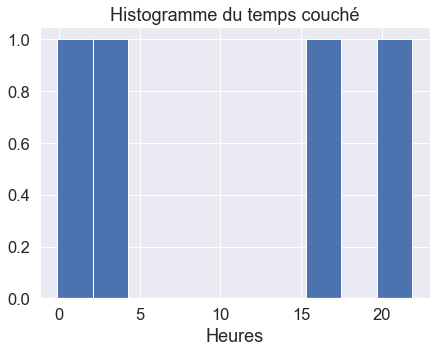

In [30]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot()
ax.hist(df[df.activity_type=='Coucher (nuit)'].timespent.astype(np.timedelta64)//1e9//3600 , align='left')
ax.set_xlabel('Heures')
plt.title('Histogramme du temps couché')
fig.show(warn=False)

### Distribution du temps selon les activités

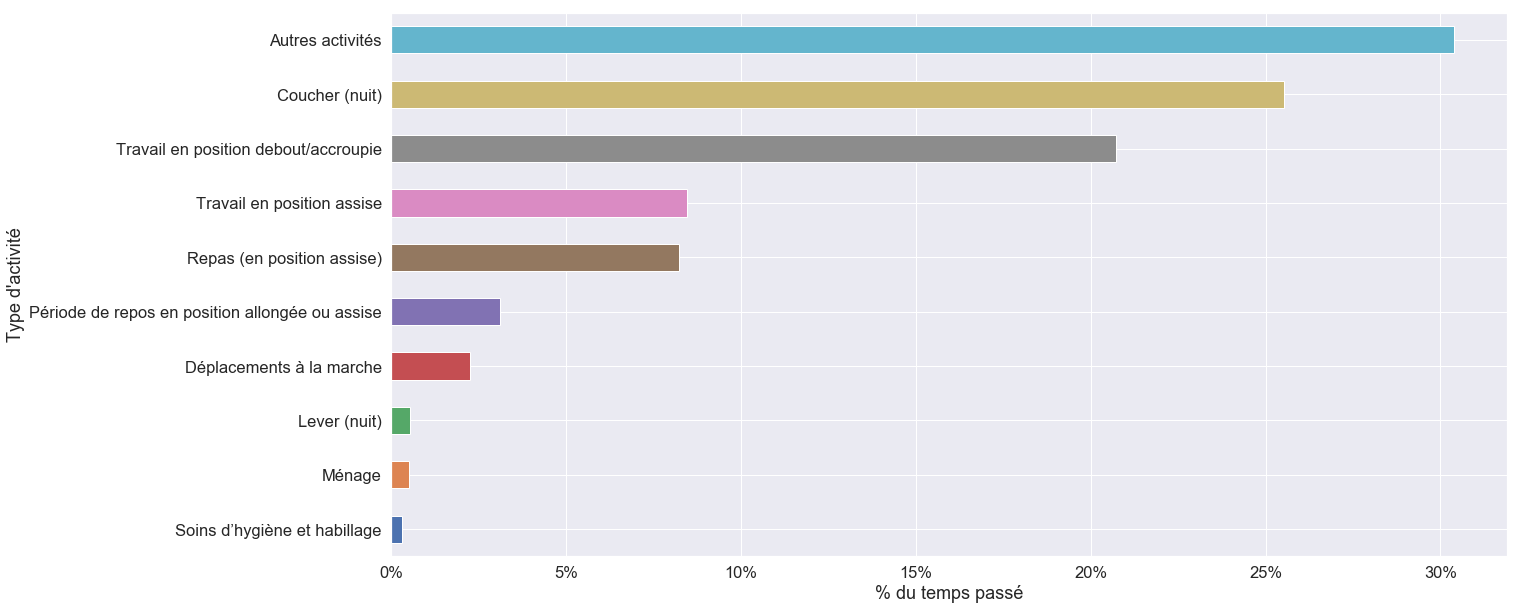

In [31]:
fig = plt.figure()
(df.groupby('activity_type').timespent.sum().astype(np.timedelta64)/df.timespent.astype(np.timedelta64).sum()).sort_values(ascending=True).plot.barh()
vals = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.ylabel('Type d\'activité')
plt.xlabel('% du temps passé')
plt.show()

In [32]:
df['tmp'] = df.activity_name + ';'
activity_details = df.groupby('activity_type').tmp.sum()
df = df.drop(columns=['tmp',])

display(Markdown('## Détails des activités'))

for name, activity_detail in activity_details.iteritems():
    activity_str = activity_detail.split(';')
    activity_str = [x.strip() for x in activity_str]
    activity_str = list(set(activity_str))
    activity_str = list(filter(None, activity_str))
    activity_str = '<br>-'.join(activity_str)
    display(Markdown('**{name}**<br> -{activity_str}'.format(name=name, activity_str=activity_str)))


## Détails des activités

**Autres activités**<br> -remise en place openIMU (calibration) & montre<br>-j'enlève les capteurs et les remets à charger<br>-remise en place des capteurs<br>-labo fini, je me change donc j'enlève les capteurs quelques minutes<br>-calibration openIMU & clic activité sur la montre<br>-station complétée, j'enlève tout. assez pour aujourd'hui<br>-fini le travail - j'enlève openIMU & montre<br>-assez pour aujourd'hui, j'enlève tout l'attirail!<br>-suite du 25 août 2018

**Coucher (nuit)**<br> -sieste & douche - j'enlève les capteurs<br>-fini! j'enlève les capteurs<br>-j'enlève tout et au lit<br>-c'est l'heure de la sieste - j'enlève les capteurs

**Déplacements à la marche**<br> -il fait beau: balade dehors<br>-rangement/gestion de labo<br>-préparation en prévision de la station d'échantillonnage<br>-balade & virée à la timonerie

**Lever (nuit)**<br> -remise en place openIMU (calibration) & montre<br>-douche, déjeuner, dormir - je remets les capteurs en place<br>-remise en place des capteurs - 27 août<br>-mise en place openIMU (calibration) & montre - 22 août<br>-mise en place des capteurs - 25 août<br>-mise en place des capteurs - 26 août<br>-mise en place des capteurs - 29 août<br>-mise en place openIMU (calibration) + montre 21 août<br>-mise en place des capteurs - 27 août<br>-mise en place de l'openIMU (calibration) & montre - 23 août

**Ménage**<br> -un peu de rangement de cabine / lessive<br>-nettoyage de la cuisine après le repas

**Période de repos en position allongée ou assise**<br> -j'enlève tout, sieste. je mets openIMU & montre à charger<br>-film<br>-(longue!) sieste<br>-ordinateur en paresseuse dans mon lit : )

**Repas (en position assise)**<br> -fini!! lunch : )<br>-lunch<br>-déjeuner<br>-souper<br>-pause & lunch<br>-pause/collation

**Soins d’hygiène et habillage**<br> -changement de vêtements donc j'enlève tout et remets/recalibre<br>-station complétée, je me change donc j'enlève tout

**Travail en position assise**<br> -science meeting<br>-ordinateur - ça brasse, on brise de la glace : )<br>-ordinateur<br>-lecture & travail ordinateur<br>-ordinateur - il neige dehors...<br>-travail sur le pont<br>-ordinateur - pour compléter le journal de bord des derniers jours<br>-lecture

**Travail en position debout/accroupie**<br> -chill à la timonerie - pas vraiment du travail, mais debout!<br>-préparation au labo en prévision de la station d'échantillonnage<br>-travail au labo (clic activité sur la montre)<br>-réparation du chalut / travail dehors & au labo<br>-travail sur le pont<br>-préparation<br>-travail au labo<br>-station d'échantillonnage - travail sur le pont<br>-préparation en prévision de la station d'échantillonnage<br>-timonerie

# Commentaires

In [35]:
for day, commentaire in df_values.commentaires.iteritems():
    display(Markdown('**{day}**<br> -{commentaire}'.format(day=day.strftime('%Y-%m-%d'), commentaire=commentaire)))

**2018-08-21**<br> -

**2018-08-22**<br> -À 9:15, en enlevant l'openIMU je remarque qu'il est inscrit logging off. Est-ce ainsi depuis longtemps? Aucune idée...

**2018-08-23**<br> -Commentaires généraux à faire, valides pour les derniers jours:

- C'est assez long de remplir les documents. En période d'échantillonnage, je n'arrive pas à compléter le tout au fur et à mesure. Je dois donc tout noter et recopier via les formulaires.
- Les indications concernant le niveau de fatigue, stress et effort sont difficiles à évaluer parce que l'horaire à bord n'est pas régulier; je suis donc à la fois fatiguée et reposée pour une même fiche du journal.
- Les catégories d'activités sont aussi grossières. À aucun moment je ne choisis escaliers alors que tous les déplacements à bord nécessite le passage via des escaliers. Le travail sur le pont et au labo est tout à la fois debout stationnaire, en déplacement, accroupi. Difficile de choisir un seul élément.
- N'ayant pas d'heure visible sur la montre, je prends l'heure là où c'est possible pour noter le début et la fin des différentes activités. Il y a des variations d'heures selon le lieu de lecture. Par exemple, l'heure affichée au labo n'est pas la même que celle dans la cabine ou celle de mon ordinateur. 
- Le port des 2 capteurs est très inconfortable. Je dois serrer la sangle de l'openIMU significativement pour qu'il demeure en place. J'ai donc maintenant un hématome à l'intérieur du bras. De plus, je l'accroche sans arrêt à bord. Concernant la montre, comme elle est grosse, avec les vêtements de terrain, le manteau Mustang et les gants, la pression exercée est grande et mon poignet est maintenant sensible en permanence. Elle n'a pas été submergée mais le moins qu'on puisse dire c'est que ça résistance aux éclaboussures aura été testée!

**2018-08-25**<br> -Pas d'échantillonnage aujourd'hui; nous devons porter assistance à un navire échoué dans le golfe de Boothia. Journée relax donc avec pas mal de temps devant l'ordi...

**2018-08-25**<br> -

**2018-08-26**<br> -

**2018-08-27**<br> -

**2018-08-28**<br> -

**2018-08-29**<br> -

In [36]:
!jupyter  nbconvert --to=html --template hideinput  "Analyses-SN2.ipynb"

[NbConvertApp] Converting notebook Analyses-SN2.ipynb to html
[NbConvertApp] Writing 367329 bytes to Analyses-SN2.html
